#### This code generates large dataframe containing multiple timeseries

In [1]:
%matplotlib inline
from time import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

#from sklearn.model_selection import cross_val_score
#from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import LabelBinarizer

from pandas.tseries.offsets import *

Using TensorFlow backend.


#### parameters to set

In [3]:
# fix random seed for reproducibility
np.random.seed(7)

n_series = 5
start_date = '2017-08-01 00:00:00'
end_date = '2017-08-04 23:59:59'

# regular behaviour
max_noise_amplitude = 0.05 # all the timeseries will have values between 0 and 1

# anomalies
p_anomaly = 10E-6
max_anomaly_duration = 4*3600 # 4 h

# tuning parameters
ref = 8
sub = 1
chance = ref/(sub+ref)
cut = chance + (1-chance) * 0.05
print('chance:',chance, '\tcut:', cut)
ref = ref * Hour()
sub = sub * Hour()

chance: 0.8888888888888888 	cut: 0.8944444444444444


#### generate normal data

In [4]:
dti=pd.DatetimeIndex(start=start_date,end=end_date, freq='s')
n_timesteps = len(dti)
df = pd.DataFrame()
for s in range(n_series):
    mean=random.random()
    std = max_noise_amplitude/random.randint(1, 16)
    print ('link:',s, '\tmean:',mean,'\tstd:', std)
    v = np.random.normal(mean, std, n_timesteps) 
    df['link '+str(s)] = pd.Series(v)
df['Flag']=0
df['score']=0.5
df.index = dti
#df.head()

link: 0 	mean: 0.4201149195809416 	std: 0.005
link: 1 	mean: 0.8169418317687386 	std: 0.0125
link: 2 	mean: 0.36579657433081103 	std: 0.004166666666666667
link: 3 	mean: 0.083158280575103 	std: 0.05
link: 4 	mean: 0.2134954192244356 	std: 0.0071428571428571435


#### generate anomalies

In [5]:
to_generate = int(n_timesteps * p_anomaly)
for a in range(to_generate):
    affects = random.sample(range(n_series), random.randint(1, n_series))
    duration = int(max_anomaly_duration * random.random())
    start = int(n_timesteps * random.random())
    end = min(start+duration, n_timesteps)
    print('affected:', affects, df.iloc[start].name, df.iloc[end].name)
    for s in affects:
        df.iloc[start:end,s] = df.iloc[start:end,s] + (random.random() - 0.5) * random.random() * 0.3
    df.iloc[start:end,n_series]=1
        

affected: [1, 4] 2017-08-04 13:02:57 2017-08-04 14:32:15
affected: [1, 2, 4] 2017-08-02 08:46:01 2017-08-02 10:51:36
affected: [0, 1, 3, 4, 2] 2017-08-01 04:34:56 2017-08-01 06:52:23


#### enforce range

In [6]:
df[df<0] = 0
df[df>1] = 1

#### plot timeseries

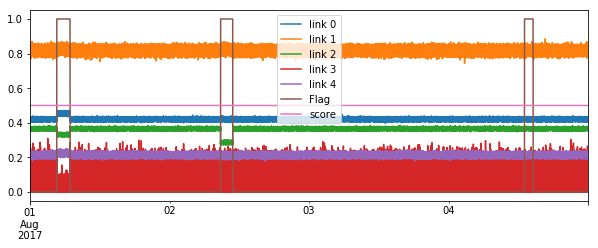

In [7]:
df.plot(figsize=(10,3.5))

#### create NN

In [8]:
def getModel():
    model = Sequential()
    model.add(Dense(units=n_series*2, input_shape=(n_series,), activation='relu' ))
#         model.add(Dropout(0.5))
    model.add(Dense(units=n_series, activation='relu'))
#         model.add(Dropout(0.5))
    model.add(Dense(units=1, activation='sigmoid'))
#     model.compile(loss='hinge', optimizer='sgd', metrics=['binary_accuracy'])
#        model.compile(loss='mse',optimizer='rmsprop', metrics=['accuracy'])
    model.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
#     model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
    return model

def plotHist(hist):
    es=len(hist.history['loss'])
    x = np.linspace(0,es-1,es)
    plt.plot(x, hist.history['loss'], '--', linewidth=2, label='loss')
    plt.plot(x, hist.history['acc'], '-', linewidth=2, label='acc')
    plt.legend()
    plt.show()

#### functions

In [9]:
def check_for_anomaly(ref, sub, count):
    
    y_ref = pd.DataFrame([0] * ref.shape[0])
    y_ref.index=ref.index
    X_ref=ref
    del X_ref['Flag']
    del X_ref['score']
    
    y_sub = pd.DataFrame([1] * sub.shape[0])
    y_sub.index=sub.index
    X_sub=sub
    del X_sub['Flag']
    del X_sub['score']
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    
    X_train_s, y_train_s = shuffle(X_train, y_train)
    
    m=getModel()
    hist = m.fit(X_train_s.values, y_train_s.values, epochs=100, verbose=0, shuffle=True, batch_size=256)

    
    loss_and_metrics = m.evaluate(X_test.values, y_test.values)#, batch_size=256)
    #print(loss_and_metrics)

    if loss_and_metrics[1] > cut:# or not count%5: 
        plotHist(hist)
#         plot_roc(fpr, tpr, auc_score)
#         filename='tree_'+sub.index.min().strftime("%Y-%m-%d_%H")
#         tree.export_graphviz(clf.estimators_[0] , out_file=filename +'_1.dot') 
#         tree.export_graphviz(clf.estimators_[1] , out_file=filename +'_2.dot') 
        
    return loss_and_metrics[1]

#### Looping over time intervals

9632/9720 [============================>.] - ETA: 0s
 2017-08-01 09:00:00 	refes: 28800 	subjects: 3600 	score: 0.888888888889
0 took: 37.92408013343811
8672/9720 [=========================>....] - ETA: 0s
 2017-08-01 10:00:00 	refes: 28800 	subjects: 3600 	score: 0.888888888889
1 took: 36.285638093948364
9600/9720 [============================>.] - ETA: 0s
 2017-08-01 11:00:00 	refes: 28800 	subjects: 3600 	score: 0.888888888889
2 took: 36.68914008140564
9216/9720 [===========================>..] - ETA: 0s
 2017-08-01 12:00:00 	refes: 28800 	subjects: 3600 	score: 0.888888888889
3 took: 37.38019037246704
8928/9720 [==========================>...] - ETA: 0s
 2017-08-01 13:00:00 	refes: 28800 	subjects: 3600 	score: 0.888888888889
4 took: 37.068488359451294
9408/9720 [============================>.] - ETA: 0s
 2017-08-01 14:00:00 	refes: 28800 	subjects: 3600 	score: 0.888888888889
5 took: 36.8801748752594
8800/9720 [==========================>...] - ETA: 0s
 2017-08-01 15:00:00 	refes:

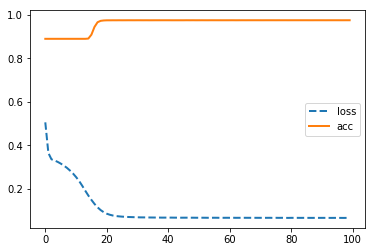


 2017-08-02 10:00:00 	refes: 28800 	subjects: 3600 	score: 0.974074074074
25 took: 34.8916654586792
9696/9720 [============================>.] - ETA: 0s
 2017-08-02 11:00:00 	refes: 28800 	subjects: 3600 	score: 0.888374485597
26 took: 33.45083546638489
9568/9720 [============================>.] - ETA: 0s
 2017-08-02 12:00:00 	refes: 28800 	subjects: 3600 	score: 0.888888888889
27 took: 33.81573462486267
9632/9720 [============================>.] - ETA: 0s
 2017-08-02 13:00:00 	refes: 28800 	subjects: 3600 	score: 0.888888888889
28 took: 37.915685415267944
9632/9720 [============================>.] - ETA: 0s
 2017-08-02 14:00:00 	refes: 28800 	subjects: 3600 	score: 0.888888888889
29 took: 35.03508019447327
9536/9720 [============================>.] - ETA: 0s
 2017-08-02 15:00:00 	refes: 28800 	subjects: 3600 	score: 0.888888888889
30 took: 36.601173877716064
9632/9720 [============================>.] - ETA: 0s
 2017-08-02 16:00:00 	refes: 28800 	subjects: 3600 	score: 0.888888888889


9312/9720 [===========================>..] - ETA: 0s
 2017-08-04 16:00:00 	refes: 28800 	subjects: 3600 	score: 0.888888888889
79 took: 37.77143955230713
8928/9720 [==========================>...] - ETA: 0s
 2017-08-04 17:00:00 	refes: 28800 	subjects: 3600 	score: 0.888888888889
80 took: 38.598724365234375
8896/9720 [==========================>...] - ETA: 0s
 2017-08-04 18:00:00 	refes: 28800 	subjects: 3600 	score: 0.888888888889
81 took: 37.72632384300232
9568/9720 [============================>.] - ETA: 0s
 2017-08-04 19:00:00 	refes: 28800 	subjects: 3600 	score: 0.888888888889
82 took: 43.079944133758545
9472/9720 [============================>.] - ETA: 0s
 2017-08-04 20:00:00 	refes: 28800 	subjects: 3600 	score: 0.888888888889
83 took: 38.480863094329834
9472/9720 [============================>.] - ETA: 0s
 2017-08-04 21:00:00 	refes: 28800 	subjects: 3600 	score: 0.888888888889
84 took: 38.71669101715088
9120/9720 [===========================>..] - ETA: 0s
 2017-08-04 22:00:00

In [10]:
#find min and max timestamps

start = df.index.min()
end = df.index.max()

#round start 
start.seconds=0
start.minutes=0


# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    startt = time()
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = df[(df.index >= ref_start) & (df.index < ref_end)]
    sub_df = df[(df.index >= ref_end) & (df.index < ti)]
    score = check_for_anomaly(ref_df, sub_df, count)
    df.loc[(df.index>=ref_end) & (df.index<=ti),['score']] = score
    print('\n',ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tscore:', score)
    ti = ti + sub
    print(count, "took:", time()-startt)
    count=count+1
#     if count>2: break
    


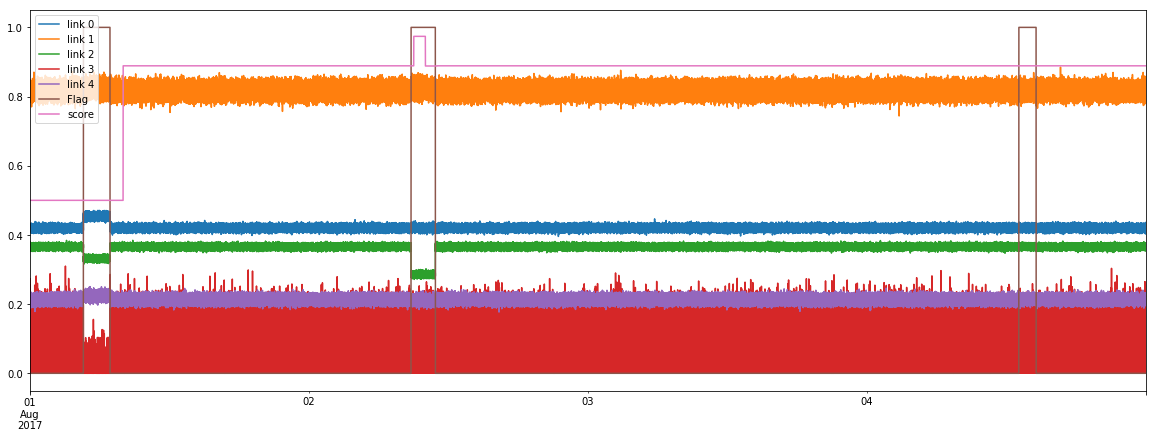

In [11]:
df.plot(figsize=(20,7))


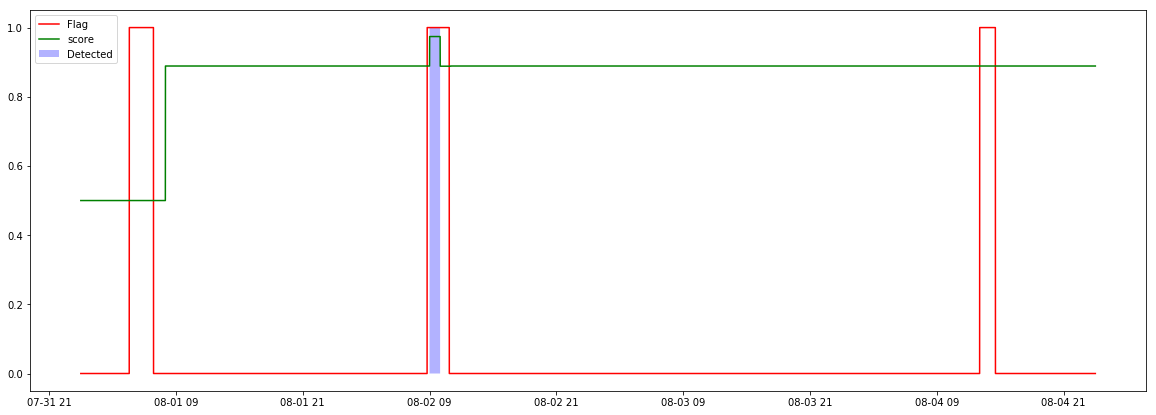

In [12]:
fig, ax = plt.subplots(figsize=(20,7))
df.loc[:,'Detected'] = 0
df.loc[df.score>cut,'Detected']=1
df.head()
ax.plot(df.Flag, 'r')
ax.plot(df.score,'g')
ax.fill( df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.show()

In [13]:
def plot_roc(fpr,tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], linestyle='--', color='r',label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()